# Assignment 4
#### Author: Lucas Schmidt Ferreira de Araujo

In [262]:
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import optimize
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [213]:
start_date = '2020-01-01'
end_date = '2025-01-07'
expiration_date = '2025-02-07'
ticker = 'AMD'
stock = yf.download(ticker, start=start_date, end=end_date)
stock.columns = stock.columns.droplevel(1)
stock['Log Return'] = np.log(stock['Adj Close'] / stock['Adj Close'].shift(1))

calls = yf.Ticker(ticker).option_chain(expiration_date).calls

[*********************100%***********************]  1 of 1 completed


In [230]:
# stock.to_csv('stock.csv')
# calls.to_csv('calls.csv')

In [214]:
stock

Price,Adj Close,Close,High,Low,Open,Volume,Log Return
Date,,,,,,,
2020-01-02 00:00:00+00:00,49.099998,49.099998,49.250000,46.630001,46.860001,80331100,NaN
2020-01-03 00:00:00+00:00,48.599998,48.599998,49.389999,47.540001,48.029999,73127400,-0.010236
2020-01-06 00:00:00+00:00,48.389999,48.389999,48.860001,47.860001,48.020000,47934900,-0.004330
2020-01-07 00:00:00+00:00,48.250000,48.250000,49.389999,48.040001,49.349998,58061400,-0.002897
2020-01-08 00:00:00+00:00,47.830002,47.830002,48.299999,47.139999,47.849998,53767000,-0.008743
...,...,...,...,...,...,...,...
2024-12-30 00:00:00+00:00,122.440002,122.440002,124.099998,122.349998,123.559998,30501600,-0.022211
2024-12-31 00:00:00+00:00,120.790001,120.790001,123.550003,120.139999,123.099998,30203400,-0.013568
2025-01-02 00:00:00+00:00,120.629997,120.629997,123.139999,119.440002,122.290001,34256200,-0.001326


<Axes: xlabel='Date', ylabel='Log Return'>

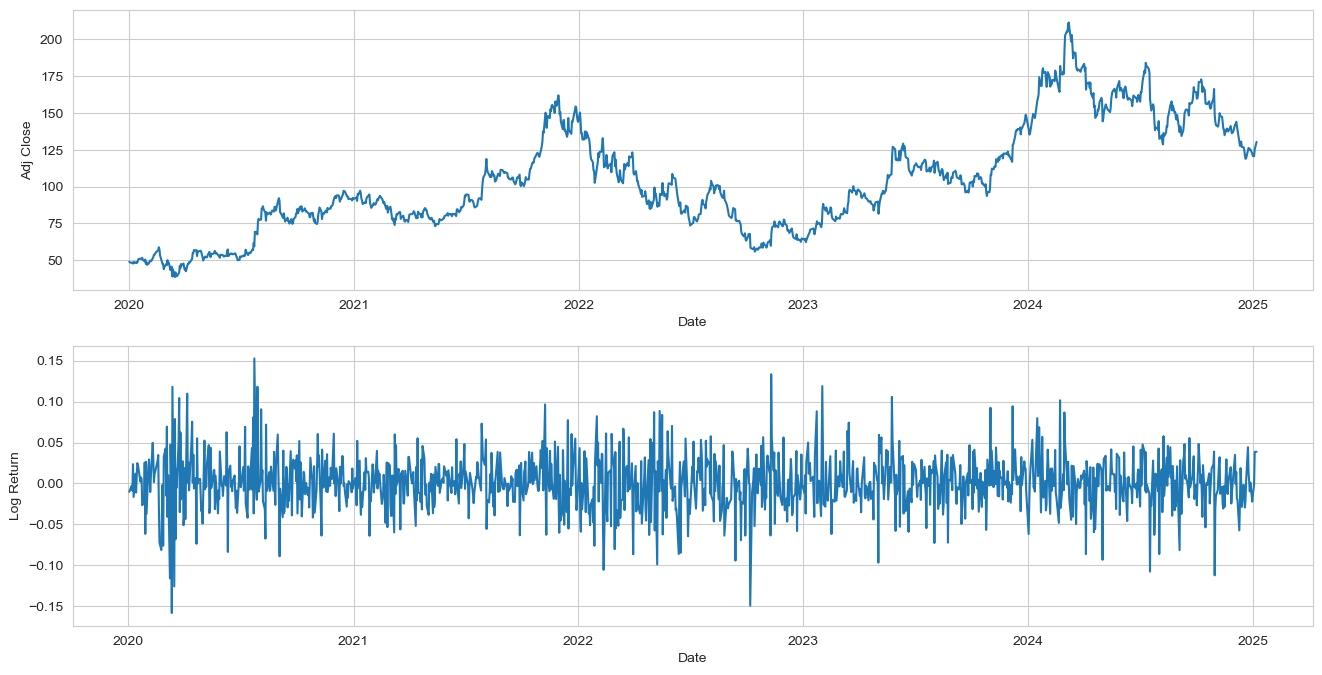

In [215]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
sns.lineplot(ax = axs[0], data = stock['Adj Close'])
sns.lineplot(ax = axs[1], data = stock['Log Return'])

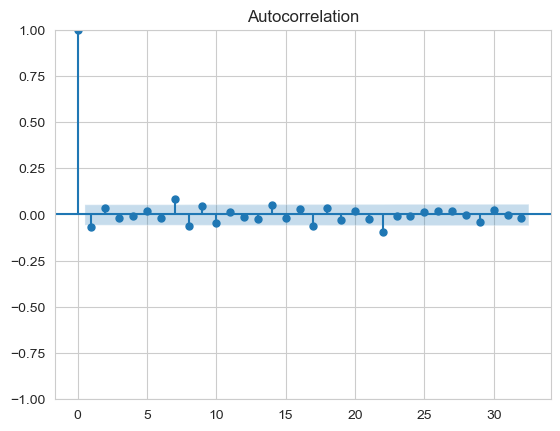

In [289]:
plot_acf(stock['Log Return'].dropna())
plt.show()

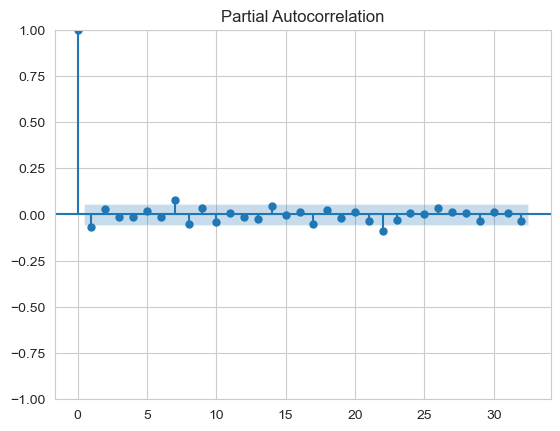

In [292]:
plot_pacf(stock['Log Return'].dropna())
plt.show()

In [216]:
def historical_volatility(returns, window_size):
    return returns.rolling(window = window_size).std() * np.sqrt(252)

def EWMA_volatility(returns, lambda_ = 0.94):
    return np.sqrt((1-lambda_) * (returns**2).ewm(alpha=1-lambda_).sum()) * np.sqrt(252)

def GARCH_volatility(returns):
    model = arch_model(returns.dropna() * 100, vol='Garch', p=1, q=1)
    fitted_model = model.fit()
    return fitted_model.conditional_volatility / 10

In [217]:
stock['Historical Volatility 21'] = historical_volatility(stock['Log Return'], 21)
stock['Historical Volatility 63'] = historical_volatility(stock['Log Return'], 63)
stock['Historical Volatility 252'] = historical_volatility(stock['Log Return'], 252)
stock['EWMA Volatility'] = EWMA_volatility(stock['Log Return'])
stock['GARCH Volatility'] = GARCH_volatility(stock['Log Return'])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7477.528479246718
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3310.3230649831257
Iteration:      3,   Func. Count:     24,   Neg. LLF: 3503.2513592758714
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3258.0957062087127
Iteration:      5,   Func. Count:     38,   Neg. LLF: 3294.4231619740076
Iteration:      6,   Func. Count:     44,   Neg. LLF: 3257.884418079261
Iteration:      7,   Func. Count:     49,   Neg. LLF: 3257.8837864886145
Iteration:      8,   Func. Count:     54,   Neg. LLF: 3257.8835319939035
Iteration:      9,   Func. Count:     59,   Neg. LLF: 3257.8835287102374
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3257.883528711271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3257.8835287102374
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


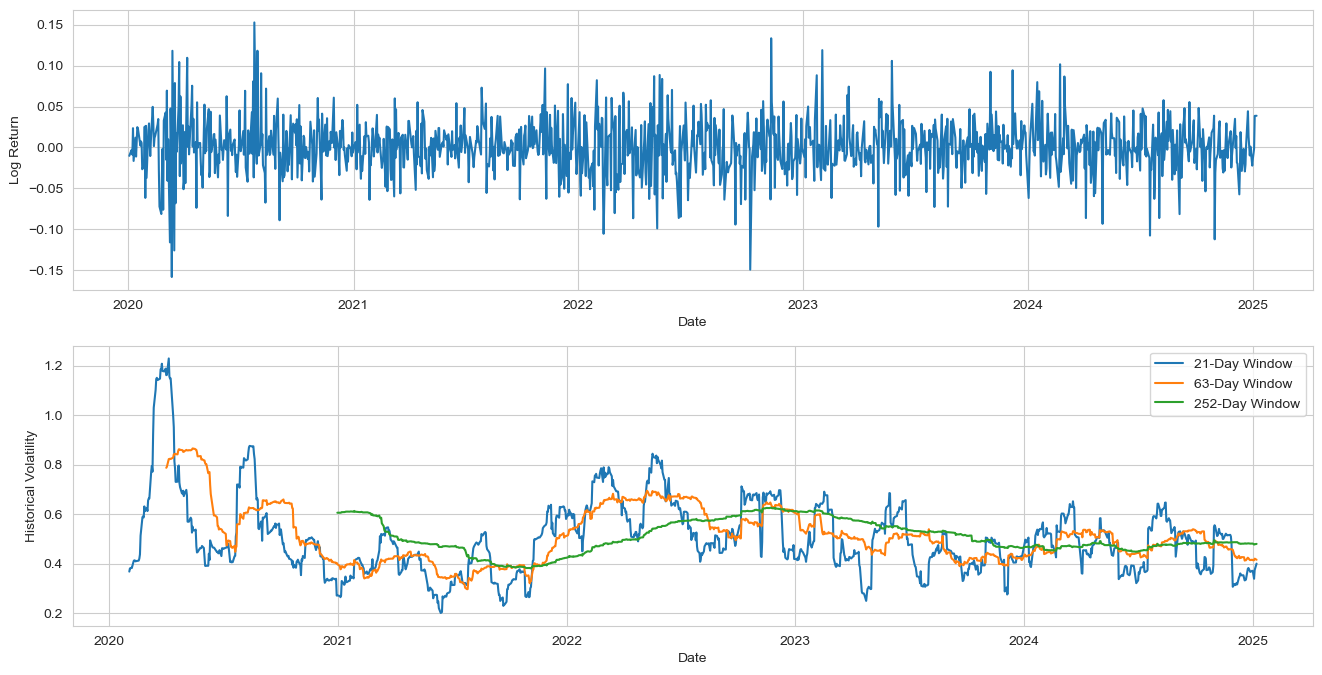

In [218]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
sns.lineplot(ax = axs[0], data = stock['Log Return'])
sns.lineplot(ax = axs[1], data=stock['Historical Volatility 21'], label='21-Day Window')
sns.lineplot(ax = axs[1], data=stock['Historical Volatility 63'], label='63-Day Window')
sns.lineplot(ax = axs[1], data=stock['Historical Volatility 252'], label='252-Day Window')
axs[1].set_ylabel('Historical Volatility')
axs[1].legend()  

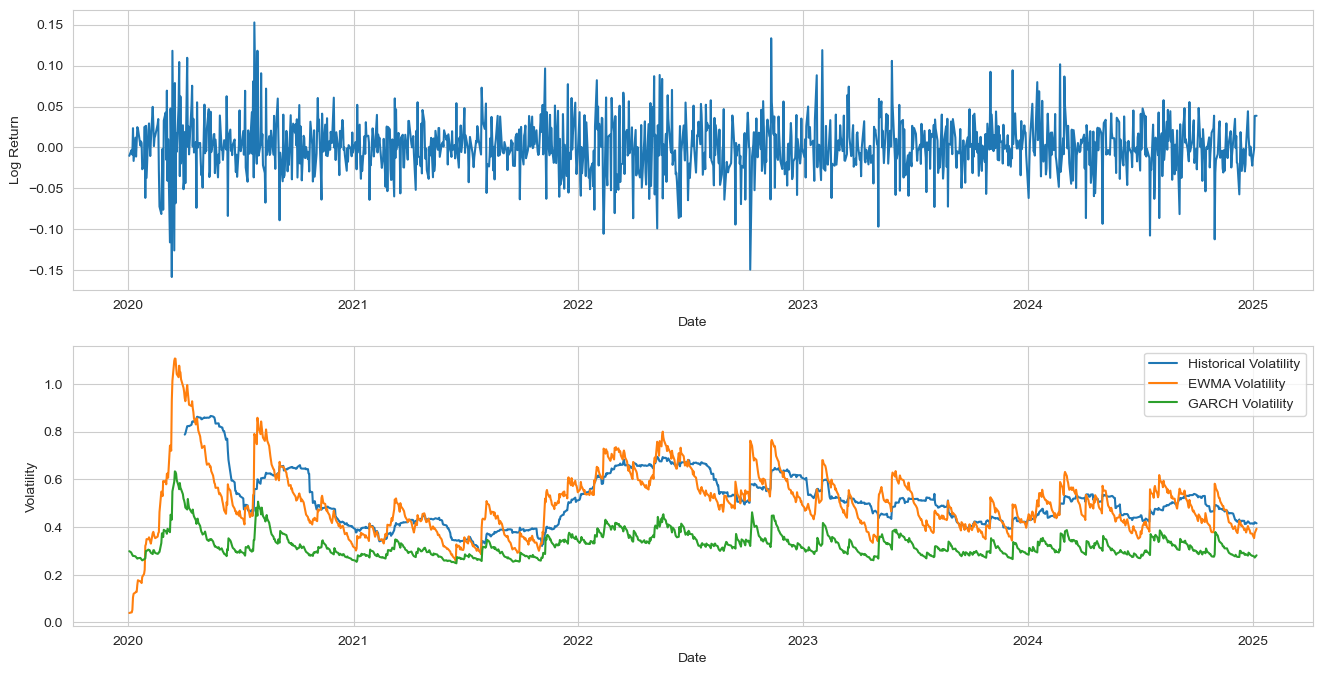

In [219]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
sns.lineplot(ax = axs[0], data = stock['Log Return'])
sns.lineplot(ax = axs[1], data=stock['Historical Volatility 63'], label='Historical Volatility')
sns.lineplot(ax = axs[1], data=stock['EWMA Volatility'], label='EWMA Volatility')
sns.lineplot(ax = axs[1], data=stock['GARCH Volatility'], label='GARCH Volatility')
axs[1].set_ylabel('Volatility')
axs[1].legend()  

In [220]:
calls.head(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AMD250207C00065000,2025-01-06 16:51:55+00:00,65.0,66.00,64.85,65.85,10.200001,18.279572,1.0,2,0.828127,True,REGULAR,USD
1,AMD250207C00070000,2025-01-02 17:29:10+00:00,70.0,50.85,59.50,60.80,0.000000,0.000000,NaN,1,1.149418,True,REGULAR,USD
2,AMD250207C00075000,2024-12-26 15:05:19+00:00,75.0,51.60,54.50,55.90,0.000000,0.000000,NaN,1,1.076176,True,REGULAR,USD
3,AMD250207C00080000,2025-01-06 14:34:19+00:00,80.0,50.00,49.75,51.10,6.400002,14.678903,20.0,1,0.720706,True,REGULAR,USD
4,AMD250207C00090000,2025-01-06 15:55:33+00:00,90.0,39.40,40.30,40.90,8.650002,28.130085,10.0,61,0.664066,True,REGULAR,USD


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


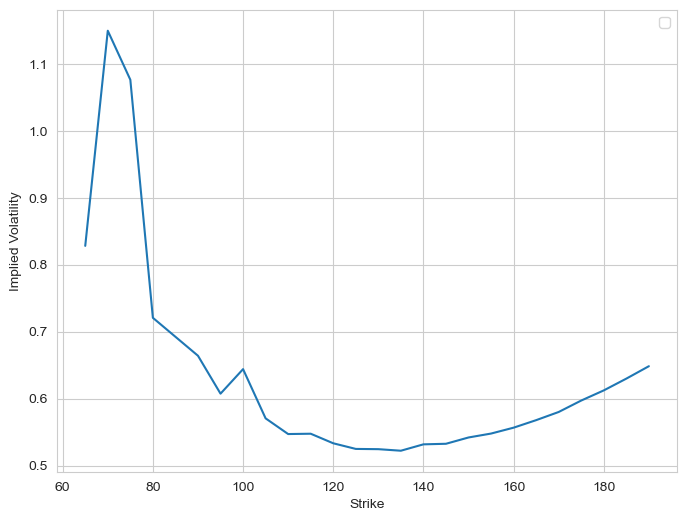

In [221]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(ax = ax, data=calls, x = 'strike', y = 'impliedVolatility') 
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
ax.legend()  

In [224]:
calls[calls['contractSymbol'] == 'AMD250207C00130000']	

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
12,AMD250207C00130000,2025-01-06 17:55:28+00:00,130.0,8.36,8.3,8.4,2.51,44.112473,604.0,1078,0.524541,True,REGULAR,USD


| Method                                  | Value    |
| --------------------------------------- | -------- |
| Historical Volatility 21-Day Window     | 0.399987 |
| Historical Volatility 63-Day Window     | 0.415609 |
| Historical Volatility 252-Day Window    | 0.479725 | 
| EWMA Volatility                         | 0.392776 |
| GARCH Volatility                        | 0.281531 |
| Implied Volatility                      | 0.524541 |

In the context of option prices, historical volatility with a 252-day window appears to be the best choice, as the estimated volatility is closest to the implied volatility.

In [237]:
stock

Price,Adj Close,Close,High,Low,Open,Volume,Log Return,Historical Volatility 21,Historical Volatility 63,Historical Volatility 252,EWMA Volatility,GARCH Volatility
Date,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,49.099998,49.099998,49.250000,46.630001,46.860001,80331100,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 00:00:00+00:00,48.599998,48.599998,49.389999,47.540001,48.029999,73127400,-0.010236,NaN,NaN,NaN,0.039800,0.298819
2020-01-06 00:00:00+00:00,48.389999,48.389999,48.860001,47.860001,48.020000,47934900,-0.004330,NaN,NaN,NaN,0.042102,0.293644
2020-01-07 00:00:00+00:00,48.250000,48.250000,49.389999,48.040001,49.349998,58061400,-0.002897,NaN,NaN,NaN,0.042345,0.288065
2020-01-08 00:00:00+00:00,47.830002,47.830002,48.299999,47.139999,47.849998,53767000,-0.008743,NaN,NaN,NaN,0.053303,0.282830
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 00:00:00+00:00,122.440002,122.440002,124.099998,122.349998,123.559998,30501600,-0.022211,0.371024,0.415812,0.480956,0.372204,0.279039
2024-12-31 00:00:00+00:00,120.790001,120.790001,123.550003,120.139999,123.099998,30203400,-0.013568,0.369475,0.413796,0.481054,0.364701,0.279281
2025-01-02 00:00:00+00:00,120.629997,120.629997,123.139999,119.440002,122.290001,34256200,-0.001326,0.338834,0.413739,0.477143,0.353628,0.276540


In [256]:
stock['Realized Volatility'] = np.abs(stock['Log Return']) * np.sqrt(252)
stock['Realized Volatility Prev'] = stock['Realized Volatility'].shift(1)

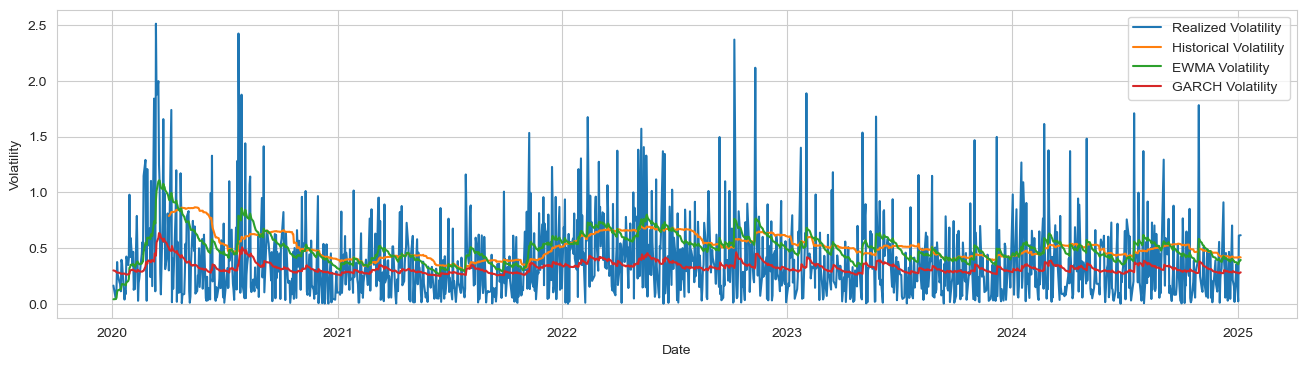

In [245]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(ax = ax, data=stock['Realized Volatility'], label='Realized Volatility')
sns.lineplot(ax = ax, data=stock['Historical Volatility 63'], label='Historical Volatility')
sns.lineplot(ax = ax, data=stock['EWMA Volatility'], label='EWMA Volatility')
sns.lineplot(ax = ax, data=stock['GARCH Volatility'], label='GARCH Volatility')
ax.set_ylabel('Volatility')
ax.legend()  

In [261]:
stock_cleaned = stock.dropna()
print(f"Historical Volatility (21-Day) RMSE: {np.sqrt(mean_squared_error(stock_cleaned['Realized Volatility'], stock_cleaned['Historical Volatility 21']))}")
print(f"Historical Volatility (63-Day) RMSE: {np.sqrt(mean_squared_error(stock_cleaned['Realized Volatility'], stock_cleaned['Historical Volatility 63']))}")
print(f"Historical Volatility (252-Day) RMSE: {np.sqrt(mean_squared_error(stock_cleaned['Realized Volatility'], stock_cleaned['Historical Volatility 252']))}")
print(f"EWMA Volatility RMSE: {np.sqrt(mean_squared_error(stock_cleaned['Realized Volatility'], stock_cleaned['EWMA Volatility']))}")
print(f"GARCH RMSE: {np.sqrt(mean_squared_error(stock_cleaned['Realized Volatility'], stock_cleaned['GARCH Volatility']))}")
print(f"R_t^2 RMSE: {np.sqrt(mean_squared_error(stock_cleaned['Realized Volatility'], stock_cleaned['Realized Volatility Prev']))}")

Historical Volatility (21-Day) RMSE: 0.34001525145272593
Historical Volatility (63-Day) RMSE: 0.3474598259890583
Historical Volatility (252-Day) RMSE: 0.36223178304733655
EWMA Volatility RMSE: 0.33124923459148586
GARCH RMSE: 0.3351350866243826
R_t^2 RMSE: 0.4694446581380596
